<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Visión por Computadora II
## Trabajo Práctico Final - Detección de Daño en Vehículos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import torch
import copy
import torchvision
import torchsummary
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageEnhance, ImageOps
from IPython.display import display
import random
from google.colab import drive
drive.mount('/content/drive')

#Modelos 
from torchvision.models.vgg import VGG19_Weights
from torchvision.models.inception import Inception_V3_Weights
from torchvision.models.resnet import ResNet50_Weights
import torchvision.models as modelos

## Cargamos el dataset

El dataset que se utilizó para este trabajo se tomó de: https://www.kaggle.com/datasets/anujms/car-damage-detection


In [2]:
# Se descomprime el dataset.
!unzip   '/content/DamageDetection.zip' > /dev/null

In [4]:
# Se guarda la ruta base en una variable.
path_base = '/content/data1a'

## Exploración inicial

In [6]:
''' Dado que las imágenes son fotos capturadas desde distintos dispositivos, 
se aplica una transformación'''
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224, 224))
                  ])

set = torchvision.datasets.ImageFolder(root=path_base+'/training', transform=data_transforms)
test_ds_original = torchvision.datasets.ImageFolder(root=path_base+'/validation', transform=data_transforms)

In [ ]:
# Cantidad de clases y de datos en el set
cantidad_clases = len(test_ds_original.classes) 
longitud_set = len(test_ds_original)
print("Cantidad de imagenes del dataset: ",longitud_set)
print("Cantidad de clases del dataset: ",cantidad_clases)

In [9]:
print("Las clases del dataset son: ",test_ds_original.classes)

Las clases del dataset son:  ['00-damage', '01-whole']


(168, 300, 3)


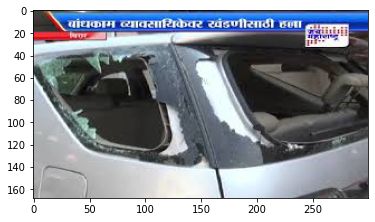

In [12]:
# Mostramos una imagen como ejemplo de la clase 1
image= mpimg.imread(test_ds_original.imgs[0][0])

print(image.shape)
plt.imshow(image)
plt.show()

(355, 569, 3)


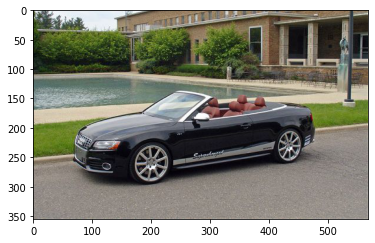

In [13]:
# Mostramos una imagen como ejemplo de la clase 2
image= mpimg.imread(test_ds_original.imgs[1000][0])

print(image.shape)
plt.imshow(image)
plt.show()

## Preparación del set para entrenamiento

### Split del dataset

In [ ]:
valid_size = 0.5
n_val = int(np.floor(valid_size * len(set)))
n_train = len(set) - n_val

train_ds_original, val_ds_original = random_split(set, [n_train, n_val])

### Transformaciones para aplicar Data Augmentation

In [16]:
# Conversión a tensor.
transform_to_tensor = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                      ])

In [17]:
# Transformaciones para el DA
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomHorizontalFlip(0.5)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=2, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])

In [18]:
# Se hace una copia del ds para trabajar sobre ella
test_ds =  copy.deepcopy(test_ds_original)
train_ds = copy.deepcopy(train_ds_original)
val_ds = copy.deepcopy(val_ds_original)

In [19]:
test_ds.dataset.transform = transform_to_tensor
train_ds.dataset.transform = aug_data_transforms
val_ds.dataset.transform = aug_data_transforms

In [ ]:
# Tamaños de los set de datos.
print ("Entrenamiento:",len(train_ds))
print ("Validación:",len(val_ds))
print ("Prueba:",len(test_ds))

## Funciones necesarias

### Función de entrenamiento

In [21]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs,model_name):

    accuracy_metric = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=cantidad_clases)# average='weighted'

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    
    best_valid_acc = 0.0 
    num_epoch = 0
    num_epoch_best_val_acc = 0
    
    for epoch in range(epochs):
        num_epoch += 1
        
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)


        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            
            
            epoch_valid_loss += criterion(output, valid_target).item()
            acuracy_step = accuracy_metric(output, valid_target).item()
            epoch_valid_accuracy += acuracy_step
            
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
        
        
        if (epoch_valid_accuracy > best_valid_acc):
            
            best_valid_acc = epoch_valid_accuracy
            
            torch.save(model.state_dict(), model_name)
            
            num_epoch_best_val_acc = num_epoch

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history, num_epoch_best_val_acc, best_valid_acc

### Función de test

In [22]:
def test(model, model_loss, model_params, test_loader):

  accuracy_metric = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=cantidad_clases)# average='weighted'

  if torch.cuda.is_available():
     model.to("cuda")
     accuracy_metric.to("cuda")

  model.load_state_dict(torch.load(model_params))
  model.eval()
  test_loss = 0.0
  test_accuracy = 0.0

  for test_data, test_target in test_loader:
    if torch.cuda.is_available():
          test_data, test_target = test_data.cuda(), test_target.cuda()
    output = model(test_data)
    test_loss += model_loss(output, test_target).item()
    test_accuracy += accuracy_metric(output, test_target).item()

  test_loss = test_loss / len(test_loader)
  test_accuracy = test_accuracy / len(test_loader)

  print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))
  return test_loss, test_accuracy

## Modelo VGG19

### Transfer Learning

In [26]:
weights_vgg19 = VGG19_Weights.IMAGENET1K_V1
transforms_vgg19 = weights_vgg19.transforms()

train_ds_vgg19 = copy.deepcopy(train_ds)
val_ds_vgg19 = copy.deepcopy(val_ds)
test_ds_vgg19 = copy.deepcopy(test_ds)

train_ds_vgg19.dataset.transform = transforms_vgg19
val_ds_vgg19.dataset.transform = transforms_vgg19
test_ds_vgg19.dataset.transform = transforms_vgg19

train_loader_vgg19 = torch.utils.data.DataLoader(train_ds_vgg19, batch_size=32, shuffle=True)
valid_loader_vgg19 = torch.utils.data.DataLoader(val_ds_vgg19, batch_size=32, shuffle=True)
test_loader_vgg19 = torch.utils.data.DataLoader(test_ds_vgg19, batch_size=32, shuffle=True)

In [27]:
vgg19_model = modelos.vgg19(weights=weights_vgg19)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [28]:
# Congelamos los parametros de la red.
for param in vgg19_model.parameters():
    param.requires_grad = False

In [29]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [30]:
vgg19_model.to("cuda")
torchsummary.summary(vgg19_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Entrenamiento y validación

In [31]:
# Definimos el optimizador
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/vgg19_model.pth'

In [32]:
# Se entrena el modelo.
result_model, history_vgg19, best_epoch, best_acc_val_vgg19 = train(vgg19_model, criterion, optimizer_ft, train_loader_vgg19, valid_loader_vgg19, 20, model_name)

Epoch: 1/20 - Train loss 0.616220 - Train Accuracy 0.650369 - Valid Loss 0.454839 - Valid Accuracy 0.842771
Epoch: 2/20 - Train loss 0.420612 - Train Accuracy 0.845258 - Valid Loss 0.355873 - Valid Accuracy 0.887772
Epoch: 3/20 - Train loss 0.351633 - Train Accuracy 0.865971 - Valid Loss 0.309696 - Valid Accuracy 0.900689
Epoch: 4/20 - Train loss 0.316770 - Train Accuracy 0.879715 - Valid Loss 0.290828 - Valid Accuracy 0.890230
Epoch: 5/20 - Train loss 0.303982 - Train Accuracy 0.886153 - Valid Loss 0.267835 - Valid Accuracy 0.896802
Epoch: 6/20 - Train loss 0.277233 - Train Accuracy 0.890653 - Valid Loss 0.261294 - Valid Accuracy 0.903011
Epoch: 7/20 - Train loss 0.269670 - Train Accuracy 0.901003 - Valid Loss 0.258909 - Valid Accuracy 0.899393
Epoch: 8/20 - Train loss 0.265595 - Train Accuracy 0.892860 - Valid Loss 0.249360 - Valid Accuracy 0.895551
Epoch: 9/20 - Train loss 0.264901 - Train Accuracy 0.899723 - Valid Loss 0.244218 - Valid Accuracy 0.896015
Epoch: 10/20 - Train loss 0.

In [33]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 17


In [34]:
test_loss_vgg19, test_accuracy_vgg19 = test(vgg19_model, criterion, model_name, test_loader_vgg19)

El modelo logro un error de 0.200995 y una accuracy de 0.906809


### Gráficas

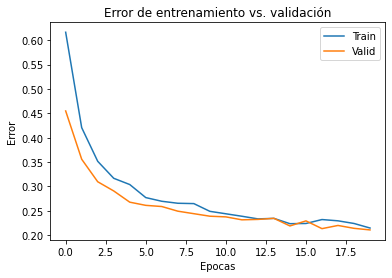

In [35]:
plt.plot(history_vgg19["train_loss"])
plt.plot(history_vgg19["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

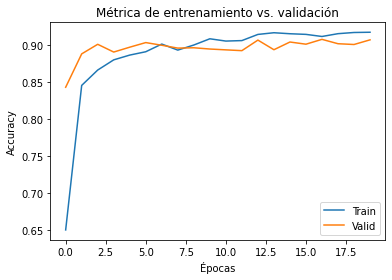

In [36]:
plt.plot(history_vgg19["train_acc"])
plt.plot(history_vgg19["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

## ResNet50

### Transfer Learning

In [159]:
weights_resnet50 = ResNet50_Weights.IMAGENET1K_V1
transforms_resnet50 = weights_resnet50.transforms()

train_ds_resnet50 = copy.deepcopy(train_ds)
val_ds_resnet50 = copy.deepcopy(val_ds)
test_ds_resnet50 = copy.deepcopy(test_ds)

train_ds_resnet50.dataset.transform = transforms_resnet50
val_ds_resnet50.dataset.transform = transforms_resnet50
test_ds_resnet50.dataset.transform = transforms_resnet50

train_loader_resnet50 = torch.utils.data.DataLoader(train_ds_resnet50, batch_size=32, shuffle=True)
valid_loader_resnet50 = torch.utils.data.DataLoader(val_ds_resnet50, batch_size=32, shuffle=True)
test_loader_resnet50 = torch.utils.data.DataLoader(test_ds_resnet50, batch_size=32, shuffle=True)

In [160]:
resnet50_model = modelos.resnet50(weights=weights_resnet50)

resnet50_model.to("cuda")

torchsummary.summary(resnet50_model, input_size=(3, 224, 224))
resnet50_model.modules

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [161]:
# Congelamos los parametros de la red.
for param in resnet50_model.parameters():
    param.requires_grad = False

In [162]:
last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [163]:
resnet50_model.to("cuda")
torchsummary.summary(resnet50_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Entrenamiento y validación

In [164]:
# Definimos el optimizador
optimizer_ft = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/resnet50_model.pth'

In [165]:
# Se entrena el modelo.
result_model, history_resnet50, best_epoch, best_acc_val_resnet50 = train(resnet50_model, criterion, optimizer_ft, train_loader_resnet50, valid_loader_resnet50, 20, model_name)

Epoch: 1/20 - Train loss 0.613546 - Train Accuracy 0.718044 - Valid Loss 0.538221 - Valid Accuracy 0.819210
Epoch: 2/20 - Train loss 0.466867 - Train Accuracy 0.879227 - Valid Loss 0.431459 - Valid Accuracy 0.866002
Epoch: 3/20 - Train loss 0.398236 - Train Accuracy 0.886539 - Valid Loss 0.382032 - Valid Accuracy 0.892427
Epoch: 4/20 - Train loss 0.358221 - Train Accuracy 0.895834 - Valid Loss 0.354500 - Valid Accuracy 0.871995
Epoch: 5/20 - Train loss 0.328848 - Train Accuracy 0.895948 - Valid Loss 0.329496 - Valid Accuracy 0.871244
Epoch: 6/20 - Train loss 0.312541 - Train Accuracy 0.895121 - Valid Loss 0.316191 - Valid Accuracy 0.878026
Epoch: 7/20 - Train loss 0.299575 - Train Accuracy 0.892828 - Valid Loss 0.300233 - Valid Accuracy 0.874037
Epoch: 8/20 - Train loss 0.285458 - Train Accuracy 0.908541 - Valid Loss 0.299640 - Valid Accuracy 0.868892
Epoch: 9/20 - Train loss 0.282765 - Train Accuracy 0.895837 - Valid Loss 0.289555 - Valid Accuracy 0.872505
Epoch: 10/20 - Train loss 0.

In [166]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 15


In [167]:
test_loss_resnet50, test_accuracy_resnet50 = test(resnet50_model, criterion, model_name, test_loader_resnet50)

El modelo logro un error de 0.219038 y una accuracy de 0.917876


### Gráficas

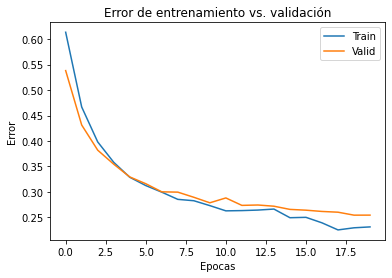

In [168]:
plt.plot(history_resnet50["train_loss"])
plt.plot(history_resnet50["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

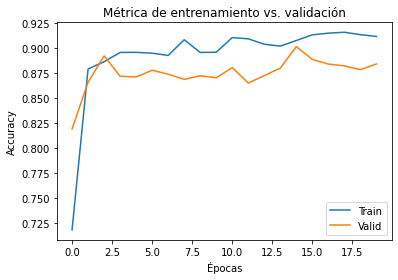

In [169]:
plt.plot(history_resnet50["train_acc"])
plt.plot(history_resnet50["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

## InceptionV3

### Transfer Learning

In [170]:
weights_inceptionv3 = Inception_V3_Weights.IMAGENET1K_V1
transforms_inceptionv3 = weights_inceptionv3.transforms()

train_ds_inceptionv3 = copy.deepcopy(train_ds)
val_ds_inceptionv3 = copy.deepcopy(val_ds)
test_ds_inceptionv3 = copy.deepcopy(test_ds)

train_ds_inceptionv3.dataset.transform = transforms_inceptionv3
val_ds_inceptionv3.dataset.transform = transforms_inceptionv3
test_ds_inceptionv3.dataset.transform = transforms_inceptionv3

print(train_ds_inceptionv3[0][0].shape)

train_loader_inceptionv3 = torch.utils.data.DataLoader(train_ds_inceptionv3, batch_size=32, shuffle=True)
valid_loader_inceptionv3 = torch.utils.data.DataLoader(val_ds_inceptionv3, batch_size=32, shuffle=True)
test_loader_inceptionv3 = torch.utils.data.DataLoader(test_ds_inceptionv3, batch_size=32, shuffle=True)

torch.Size([3, 299, 299])


In [171]:
inceptionv3_model = modelos.inception_v3(weights=weights_inceptionv3)

inceptionv3_model.to("cuda")

torchsummary.summary(inceptionv3_model, input_size=(3, 299, 299))
inceptionv3_model.modules

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

<bound method Module.modules of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(8

In [172]:
for param in inceptionv3_model.parameters():
    param.requires_grad = False

In [173]:
last_layer_in_features = inceptionv3_model.fc.in_features
inceptionv3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [174]:
inceptionv3_model.to("cuda")
torchsummary.summary(inceptionv3_model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### Entrenamiento y validación

In [175]:
# Definimos el optimizador
optimizer_ft = torch.optim.Adam(inceptionv3_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/inceptionv3_model.pth'

In [178]:
def train_inceptionv3(model, criterion, optimizer, train_loader, valid_loader, epochs,model_name):

    accuracy_metric = torchmetrics.Accuracy(task='multiclass', average='macro', num_classes=cantidad_clases)# average='weighted'

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    
    best_valid_acc = 0.0 
    num_epoch = 0
    num_epoch_best_val_acc = 0
    
    for epoch in range(epochs):
        num_epoch += 1
        
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            
            output, output_auxiliar = model(train_data)
            
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            
            epoch_valid_loss += criterion(output, valid_target).item()
            acuracy_step = accuracy_metric(output, valid_target).item()
            epoch_valid_accuracy += acuracy_step
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
        
        if (epoch_valid_accuracy > best_valid_acc):
            best_valid_acc = epoch_valid_accuracy
            torch.save(model.state_dict(), model_name)
            num_epoch_best_val_acc = num_epoch

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history, num_epoch_best_val_acc, best_valid_acc

In [179]:
# Se entrena el modelo.
result_model, history_inceptionv3, best_epoch, best_acc_val_inceptionv3 = train_inceptionv3(inceptionv3_model, criterion, optimizer_ft, train_loader_inceptionv3, valid_loader_inceptionv3, 20, model_name)

Epoch: 1/20 - Train loss 0.649533 - Train Accuracy 0.637632 - Valid Loss 0.580022 - Valid Accuracy 0.787132
Epoch: 2/20 - Train loss 0.556097 - Train Accuracy 0.777260 - Valid Loss 0.520321 - Valid Accuracy 0.838939
Epoch: 3/20 - Train loss 0.494351 - Train Accuracy 0.831021 - Valid Loss 0.475062 - Valid Accuracy 0.844829
Epoch: 4/20 - Train loss 0.460747 - Train Accuracy 0.829682 - Valid Loss 0.436667 - Valid Accuracy 0.834210
Epoch: 5/20 - Train loss 0.436234 - Train Accuracy 0.837876 - Valid Loss 0.412682 - Valid Accuracy 0.864591
Epoch: 6/20 - Train loss 0.410599 - Train Accuracy 0.856980 - Valid Loss 0.401503 - Valid Accuracy 0.862246
Epoch: 7/20 - Train loss 0.400892 - Train Accuracy 0.859799 - Valid Loss 0.391123 - Valid Accuracy 0.862461
Epoch: 8/20 - Train loss 0.385103 - Train Accuracy 0.864920 - Valid Loss 0.379295 - Valid Accuracy 0.870125
Epoch: 9/20 - Train loss 0.368486 - Train Accuracy 0.865258 - Valid Loss 0.358925 - Valid Accuracy 0.867347
Epoch: 10/20 - Train loss 0.

In [180]:
print("La mejor epoch de la ejecucion fue la",best_epoch)

La mejor epoch de la ejecucion fue la 18


In [181]:
test_loss_inceptionv3, test_accuracy_inceptionv3 = test(inceptionv3_model, criterion, model_name, test_loader_inceptionv3)

El modelo logro un error de 0.268742 y una accuracy de 0.924240


### Gráficas

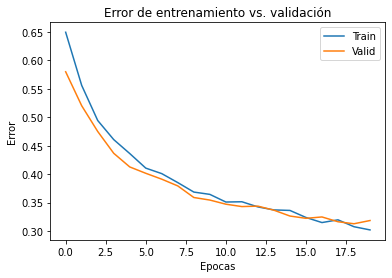

In [182]:
plt.plot(history_inceptionv3["train_loss"])
plt.plot(history_inceptionv3["valid_loss"])
plt.title("Error de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Epocas")
plt.ylabel("Error")
plt.show()

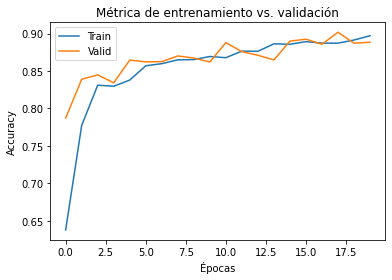

In [183]:
plt.plot(history_inceptionv3["train_acc"])
plt.plot(history_inceptionv3["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()